<a href="https://colab.research.google.com/github/najwhoas/absa-project/blob/main/absa-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import library

In [ ]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
import numpy as np
import datetime as dt
import string
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report

import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## read data + remove duplicate

In [ ]:
data = pd.read_csv('dataset_absa_revisi.csv')

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       1149 non-null   object
 1   y_rasa       1149 non-null   int64 
 2   c_rasa       1149 non-null   int64 
 3   y_pelayanan  1149 non-null   int64 
 4   c_pelayanan  1149 non-null   int64 
 5   y_tempat     1149 non-null   int64 
 6   c_tempat     1149 non-null   int64 
 7   y_harga      1149 non-null   int64 
 8   c_harga      1149 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 80.9+ KB


In [ ]:
data.shape

(1149, 9)

In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0


## case folding

In [ ]:
# mengubah jenis huruf menjadi huruf kecil
def lowercase(review_text):
  low = review_text.lower()
  return low

data['clean_review'] = data['Review'].apply(lambda low:lowercase(str(low)))

In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya. untuk ra...
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0,"tempatnya gak nyaman, banyak nyamuk. rasa maka..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0,"gak bakal balik lagi ke sini, pelayanannya bur..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0,suka dengan pelayanan mcdonald's bandung buah ...


## remove emoji, hashtag, tanda baca, superskrip, dan non-alpha

In [ ]:
# menghapus emoji menggunakan regex dan nilai unicode dari emoji
def remove_emoji(review_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', review_text)

data['clean_review'] = data['clean_review'].apply(lambda emoji: remove_emoji(emoji))


In [ ]:
# menghapus tanda baca

def remove_punctuation(review_text, default_text=" "):
  list_punct = string.punctuation
  delete_punct = str.maketrans(list_punct,' '*len(list_punct))
  new_review = ' '.join(review_text.translate(delete_punct).split())

  return new_review

data['clean_review'] = data['clean_review'].apply(lambda punct: remove_punctuation(punct))

In [ ]:
# menghapus superscript dalam ulasan yang biasa digunakan oleh pengguna dalam mengulangi kata

def remove_superscript(review_text):
  number = re.compile("["u"\U00002070"
                      u"\U000000B9"
                      u"\U000000B2-\U000000B3"
                      u"\U00002074-\U00002079"
                      u"\U0000207A-\U0000207E"
                      u"U0000200D"
                      "]+", flags=re.UNICODE)
  return number.sub(r'', review_text)

data['clean_review'] = data['clean_review'].apply(lambda num: remove_superscript(num))

In [ ]:
def remove_non_clear_symbols(word):
    # Ekspresi reguler untuk mencocokkan simbol-simbol yang tidak jelas
    pattern = r'[^\w\s]'  # Mengabaikan karakter alfanumerik
    cleaned_word = re.sub(pattern, '', word)
    return cleaned_word
data['clean_review'] = data['clean_review'].apply(lambda word: remove_non_clear_symbols(word))

In [ ]:
# melakukan pembatasan jumlah huruf menjadi dua untuk mengembalikan kata ke bentuk awal
# dan menghindari terjadinya kata ganda yang memiliki arti sama tetapi berbeda penulisan

def word_repetition(review_text):
  review = re.sub(r'(.)\1+', r'\1\1', review_text)
  return review

data['clean_review'] = data['clean_review'].apply(lambda word: word_repetition(word))

In [ ]:
# melakukan pembatasan kata berulang menjadi satu kali, seperti suka suka -> suka

def repetition(review_text):
  repeat = re.sub(r'\b(\w+)(?:\W\1\b)+', r'\1',review_text, flags=re.IGNORECASE)
  return repeat

data['clean_review'] = data['clean_review'].apply(lambda word: repetition(word))

In [ ]:
# menghapus spasi berlebih dalam ulasan

def remove_extra_whitespaces(review_text):
  review = re.sub(r'\s+',' ', review_text)
  return review

data['clean_review'] = data['clean_review'].apply(lambda extra_spaces: remove_extra_whitespaces(extra_spaces))

In [ ]:
bannedword = ['wkwk', 'wkwkw','wkwkwk','hihi','hihihii','hihihi','hehehe','hehehehe','hehe',
         'huhu','huhuu','ancok','guak','cokcok','hhmm','annya','huftt', 'nya', 'kiw', 'kiww', ' mmmmuah yummie']

re_banned_words = re.compile(r"\b(" + "|".join(bannedword) + ")\\W", re.I)

def RemoveBannedWords(toPrint):
    global re_banned_words
    return re_banned_words.sub("", toPrint)

data['clean_review'] = data['clean_review'].apply(lambda banned:RemoveBannedWords(banned))

In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0,tempatnya gak nyaman banyak nyamuk rasa makana...
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0,gak bakal balik lagi ke sini pelayanannya buru...
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0,suka dengan pelayanan mcdonald s bandung buah ...


## Slang Word

In [ ]:
!gdown --id 1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y

slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 79.4MB/s]


In [ ]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

print(clear_slangs)

[['& ', ' dan'], ['dr ', ' dari'], ['abis ', ' habis'], ['ad ', ' ada'], ['alhmdulillah ', ' alhamdulillah'], ['alhamdulilah ', ' alhamdulillah'], ['alhamdulillaah ', ' alhamdulillah'], ['alhamdulillah ', ' alhamdulillah'], ['adminnya ', ' admin nya'], ['account ', ' akun'], ['asiikk ', ' asyik'], ['alpukatnya ', ' alpukat nya'], ['amin ', ' aamiin'], ['aplikasinnya ', ' aplikasi nya'], ['aplikasinya ', ' aplikasi nya'], ['awesome ', ' luar biasa'], ['asyilk ', ' asyik'], ['antaran ', ' pengantaran'], ['apus ', ' hapus'], ['ampe ', ' sampai'], ['almt ', ' alamat'], ['almat ', ' alamat'], ['alamt ', ' alamat'], ['almtnya ', ' alamatnya'], ['apknya ', ' aplikasinya'], ['antri ', ' antre'], ['adl ', ' adalah'], ['awalnnya ', ' awalnya'], ['asem ', ' asam'], ['alumunium ', ' aluminium'], ['abis ', ' habis'], ['areaku ', ' area saya'], ['alpulat ', ' alpukat'], ['adlah ', ' adalah'], ['applikasi ', ' aplikasi'], ['apps ', ' aplikasi'], ['app ', ' aplikasi'], ['afordable ', ' affordable'], [

In [ ]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}
dict_slangs

{'&': 'dan',
 'dr': 'dari',
 'abis': 'habis',
 'ad': 'ada',
 'alhmdulillah': 'alhamdulillah',
 'alhamdulilah': 'alhamdulillah',
 'alhamdulillaah': 'alhamdulillah',
 'alhamdulillah': 'alhamdulillah',
 'adminnya': 'admin nya',
 'account': 'akun',
 'asiikk': 'asyik',
 'alpukatnya': 'alpukat nya',
 'amin': 'aamiin',
 'aplikasinnya': 'aplikasi nya',
 'aplikasinya': 'aplikasi nya',
 'awesome': 'luar biasa',
 'asyilk': 'asyik',
 'antaran': 'pengantaran',
 'apus': 'hapus',
 'ampe': 'sampai',
 'almt': 'alamat',
 'almat': 'alamat',
 'alamt': 'alamat',
 'almtnya': 'alamatnya',
 'apknya': 'aplikasinya',
 'antri': 'antre',
 'adl': 'adalah',
 'awalnnya': 'awalnya',
 'asem': 'asam',
 'alumunium': 'aluminium',
 'areaku': 'area saya',
 'alpulat': 'alpukat',
 'adlah': 'adalah',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'app': 'aplikasi',
 'afordable': 'affordable',
 'agent': 'agen',
 'agus': 'hangus',
 'apk': 'aplikasi',
 'appsnya': 'aplikasinya',
 'aah': 'ah',
 'apakh': 'apakah',
 'apalgi': 'apal

In [ ]:
clean_text = []
for review in data['clean_review']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

In [ ]:
data['clean_review'] = clean_text

## Tokenize

In [ ]:
def word_token(review_text):
  return word_tokenize(review_text)

In [ ]:
data['clean_and_tokenized'] = data['clean_review'].apply(word_token)

In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review,clean_and_tokenized
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...,"[memang, cukup, luas, dan, sepi, tempatnya, un..."
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0,tempatnya tidak nyaman banyak nyamuk rasa maka...,"[tempatnya, tidak, nyaman, banyak, nyamuk, ras..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0,tidak bakal balik lagi ke sini pelayanannya bu...,"[tidak, bakal, balik, lagi, ke, sini, pelayana..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...,"[harganya, terlalu, mahal, untuk, rasa, yang, ..."
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0,suka dengan pelayanan mcdonald s bandung buah ...,"[suka, dengan, pelayanan, mcdonald, s, bandung..."


## remove stopwords

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('popular')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Down

True

In [ ]:
# menampilkan kata stopwords bahasa indonesia
indo_stopwords = stopwords.words('indonesian')

# menghitung jumlah kata stopwords bahasa indonesia
print('Length of Indonesian stopwords:', len(indo_stopwords))
print(indo_stopwords)

Length of Indonesian stopwords: 758
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'ber

In [ ]:
stopwords_to_remove = ['tempat', 'dua', 'empat', 'setempat', 'rasa', 'merasa', 'terasa','rasanya', 'setidaknya', 'tidak', 'tidakkah', 'tidaklah', 'kurang', 'sekurangnya', 'sedikit', 'sedikitnya', 'umum', 'umumnya' ]

# Menghapus kata-kata tersebut dari daftar stopwords
modified_stopwords = [word for word in indo_stopwords if word not in stopwords_to_remove]

# Menampilkan daftar stopwords yang telah dimodifikasi
print('Length of Modified Indonesian stopwords:', len(modified_stopwords))
print(modified_stopwords)

Length of Modified Indonesian stopwords: 740
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-ka

In [ ]:
def remove_stopwords(review_text, modified_stopwords):
  tokenize = []
  for token in review_text:
    if token not in modified_stopwords:
      tokenize.append(token)

  return tokenize

data['final_text'] = data['clean_and_tokenized'].apply(lambda x: remove_stopwords(x, modified_stopwords))

In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review,clean_and_tokenized,final_text
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...,"[memang, cukup, luas, dan, sepi, tempatnya, un...","[luas, sepi, tempatnya, rasa, makanannya, menu..."
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0,tempatnya tidak nyaman banyak nyamuk rasa maka...,"[tempatnya, tidak, nyaman, banyak, nyamuk, ras...","[tempatnya, tidak, nyaman, nyamuk, rasa, makan..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0,tidak bakal balik lagi ke sini pelayanannya bu...,"[tidak, bakal, balik, lagi, ke, sini, pelayana...","[tidak, pelayanannya, buruk, makanannya, dingin]"
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...,"[harganya, terlalu, mahal, untuk, rasa, yang, ...","[harganya, mahal, rasa, mengecewakan]"
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0,suka dengan pelayanan mcdonald s bandung buah ...,"[suka, dengan, pelayanan, mcdonald, s, bandung...","[suka, pelayanan, mcdonald, s, bandung, buah, ..."


## stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [ ]:
# Fungsi untuk melakukan stemming pada setiap token dalam daftar token
def stem_tokens(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Menerapkan fungsi stem_tokens() ke kolom 'clean_and_tokenized' dan menyimpan hasilnya dalam kolom 'final_text'
data['final_text'] = data['clean_and_tokenized'].apply(lambda tokens: stem_tokens(tokens))


In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review,clean_and_tokenized,final_text
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...,"[memang, cukup, luas, dan, sepi, tempatnya, un...","[memang, cukup, luas, dan, sepi, tempat, untuk..."
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0,tempatnya tidak nyaman banyak nyamuk rasa maka...,"[tempatnya, tidak, nyaman, banyak, nyamuk, ras...","[tempat, tidak, nyaman, banyak, nyamuk, rasa, ..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0,tidak bakal balik lagi ke sini pelayanannya bu...,"[tidak, bakal, balik, lagi, ke, sini, pelayana...","[tidak, bakal, balik, lagi, ke, sini, layan, b..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...,"[harganya, terlalu, mahal, untuk, rasa, yang, ...","[harga, terlalu, mahal, untuk, rasa, yang, kec..."
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0,suka dengan pelayanan mcdonald s bandung buah ...,"[suka, dengan, pelayanan, mcdonald, s, bandung...","[suka, dengan, layan, mcdonald, s, bandung, bu..."


## Visualisasi WordCloud

In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review,clean_and_tokenized,final_text
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...,"[memang, cukup, luas, dan, sepi, tempatnya, un...","[memang, cukup, luas, dan, sepi, tempat, untuk..."
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0,tempatnya tidak nyaman banyak nyamuk rasa maka...,"[tempatnya, tidak, nyaman, banyak, nyamuk, ras...","[tempat, tidak, nyaman, banyak, nyamuk, rasa, ..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0,tidak bakal balik lagi ke sini pelayanannya bu...,"[tidak, bakal, balik, lagi, ke, sini, pelayana...","[tidak, bakal, balik, lagi, ke, sini, layan, b..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...,"[harganya, terlalu, mahal, untuk, rasa, yang, ...","[harga, terlalu, mahal, untuk, rasa, yang, kec..."
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0,suka dengan pelayanan mcdonald s bandung buah ...,"[suka, dengan, pelayanan, mcdonald, s, bandung...","[suka, dengan, layan, mcdonald, s, bandung, bu..."


In [ ]:
from collections import Counter

# Membuat string yang berisi semua token dari seluruh baris dalam kolom 'final_text'
all_tokens_text = ' '.join(data['final_text'].sum())

# Membuat objek Counter untuk menghitung kemunculan setiap kata dalam teks
word_counts = Counter(all_tokens_text.split())

# Menampilkan 10 kata dengan jumlah kemunculan terbanyak
top_words = word_counts.most_common(10)
print("Top 10 kata dengan jumlah kemunculan terbanyak:")
for word, count in top_words:
    print(f"{word}: {count}")


Top 10 kata dengan jumlah kemunculan terbanyak:
dan: 773
makan: 721
tempat: 627
layan: 607
yang: 573
tidak: 552
di: 363
enak: 348
juga: 347
sangat: 329


<ipython-input-136-c14324b8dace>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=words, y=counts, palette='autumn')


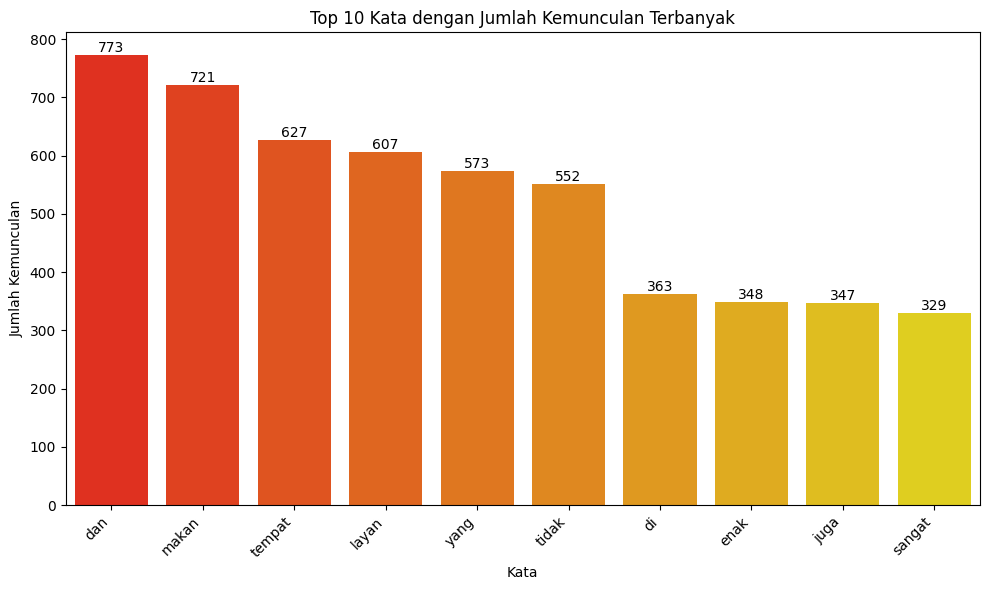

In [ ]:
# Ambil data dari top_words
words = [word for word, _ in top_words]
counts = [count for _, count in top_words]

# Buat plot menggunakan seaborn
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=words, y=counts, palette='autumn')
plt.xlabel('Kata')
plt.ylabel('Jumlah Kemunculan')
plt.title('Top 10 Kata dengan Jumlah Kemunculan Terbanyak')
plt.xticks(rotation=45, ha='right')

# Tambahkan anotasi ke setiap bar
for bar, count in zip(bars.patches, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{count}', va='bottom', ha='center')

plt.tight_layout()
plt.show()


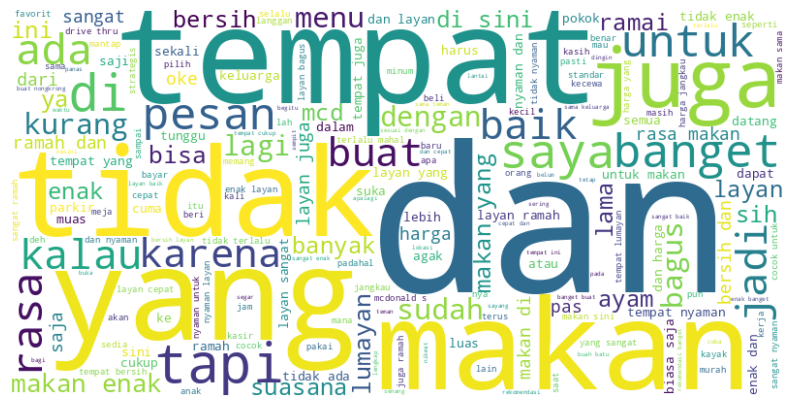

In [ ]:
# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tokens_text)

# Menampilkan wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# for i in range(len(data['final_text'])):
#     teks = ' '.join(data['final_text'][i])
#     data['final_text'][i] = teks

In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review,clean_and_tokenized,final_text
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...,"[memang, cukup, luas, dan, sepi, tempatnya, un...","[memang, cukup, luas, dan, sepi, tempat, untuk..."
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0,tempatnya tidak nyaman banyak nyamuk rasa maka...,"[tempatnya, tidak, nyaman, banyak, nyamuk, ras...","[tempat, tidak, nyaman, banyak, nyamuk, rasa, ..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0,tidak bakal balik lagi ke sini pelayanannya bu...,"[tidak, bakal, balik, lagi, ke, sini, pelayana...","[tidak, bakal, balik, lagi, ke, sini, layan, b..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...,"[harganya, terlalu, mahal, untuk, rasa, yang, ...","[harga, terlalu, mahal, untuk, rasa, yang, kec..."
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0,suka dengan pelayanan mcdonald s bandung buah ...,"[suka, dengan, pelayanan, mcdonald, s, bandung...","[suka, dengan, layan, mcdonald, s, bandung, bu..."


## Word Embedding

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install transformers -q

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import logging
import torch.optim as optim

# # Ensure tokenizer and model are initialized
# assert tokenizer is not None, "tokenizer not initialized"
# assert model is not None, "model not initialized"

In [ ]:
data.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review,clean_and_tokenized,final_text
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...,"[memang, cukup, luas, dan, sepi, tempatnya, un...","[memang, cukup, luas, dan, sepi, tempat, untuk..."
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,0,0,tempatnya tidak nyaman banyak nyamuk rasa maka...,"[tempatnya, tidak, nyaman, banyak, nyamuk, ras...","[tempat, tidak, nyaman, banyak, nyamuk, rasa, ..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,0,0,tidak bakal balik lagi ke sini pelayanannya bu...,"[tidak, bakal, balik, lagi, ke, sini, pelayana...","[tidak, bakal, balik, lagi, ke, sini, layan, b..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...,"[harganya, terlalu, mahal, untuk, rasa, yang, ...","[harga, terlalu, mahal, untuk, rasa, yang, kec..."
4,Suka dengan pelayanan mcDonald's bandung buah ...,0,0,1,1,1,1,0,0,suka dengan pelayanan mcdonald s bandung buah ...,"[suka, dengan, pelayanan, mcdonald, s, bandung...","[suka, dengan, layan, mcdonald, s, bandung, bu..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Review               1149 non-null   object
 1   y_rasa               1149 non-null   int64 
 2   c_rasa               1149 non-null   int64 
 3   y_pelayanan          1149 non-null   int64 
 4   c_pelayanan          1149 non-null   int64 
 5   y_tempat             1149 non-null   int64 
 6   c_tempat             1149 non-null   int64 
 7   y_harga              1149 non-null   int64 
 8   c_harga              1149 non-null   int64 
 9   clean_review         1149 non-null   object
 10  clean_and_tokenized  1149 non-null   object
 11  final_text           1149 non-null   object
dtypes: int64(8), object(4)
memory usage: 107.8+ KB


In [ ]:
columns_to_count = ['y_rasa', 'c_rasa', 'y_pelayanan', 'c_pelayanan', 'y_tempat', 'c_tempat', 'y_harga', 'c_harga']

# Menghitung frekuensi nilai untuk setiap kolom
for column in columns_to_count:
    print(f"Frequencies in column {column}:")
    print(data[column].value_counts())
    print()

Frequencies in column y_rasa:
y_rasa
 0    661
 1    334
-1    154
Name: count, dtype: int64

Frequencies in column c_rasa:
c_rasa
1    614
0    535
Name: count, dtype: int64

Frequencies in column y_pelayanan:
y_pelayanan
 0    496
 1    370
-1    283
Name: count, dtype: int64

Frequencies in column c_pelayanan:
c_pelayanan
1    742
0    407
Name: count, dtype: int64

Frequencies in column y_tempat:
y_tempat
 0    602
 1    393
-1    154
Name: count, dtype: int64

Frequencies in column c_tempat:
c_tempat
1    689
0    460
Name: count, dtype: int64

Frequencies in column y_harga:
y_harga
 0    882
 1    134
-1    133
Name: count, dtype: int64

Frequencies in column c_harga:
c_harga
0    828
1    321
Name: count, dtype: int64



In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
text = data

In [ ]:
# Word Embedding
def get_sentence_embedding(text: str, max_sequence_length: int):
    # _ensure_initialized()
    assert tokenizer is not None, "tokenizer not initialized"
    assert model is not None, "model not initialized"

    if isinstance(text, list): text = ' '.join(text)

    text_input = f"[CLS] {text.lower()} [SEP] [MASK]"

    tokenized_text = tokenizer.tokenize(text_input)
    segments = [1] * len(tokenized_text)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    logging.info("indexed_tokens: %s", indexed_tokens)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments])

    with torch.no_grad():
        encoded_layers = model(tokens_tensor, segments_tensors)

    last_hidden_state = encoded_layers.last_hidden_state

    token_embeddings = torch.stack([last_hidden_state])
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # swap dimensions
    token_embeddings = token_embeddings.permute(1,0,2)

    logging.info("token_embedding.size = {}".format(token_embeddings.size()))

    token_vecs = last_hidden_state[0]

    # sentence_embedding = torch.mean(token_vecs, dim=0)

    sentence_embedding = [tensor for tensor in token_vecs]
    mask_token = sentence_embedding.pop()

    if len(sentence_embedding) > max_sequence_length:
        last_token = sentence_embedding.pop()
        sentence_embedding = sentence_embedding[:max_sequence_length-1]
        sentence_embedding.append(last_token)

    sentence_embedding = [mask_token]*(max_sequence_length-len(sentence_embedding)) + sentence_embedding
    return np.array(sentence_embedding)

In [ ]:
# Assuming 'text' is your DataFrame with a column 'final_text'
text_data = text['final_text'].values
output_sentiment = text[['y_rasa', 'y_pelayanan', 'y_tempat', 'y_harga']].values
output_confidence = np.abs(text[['c_rasa', 'c_pelayanan', 'c_tempat', 'c_harga']].values)

# Split the data
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    text_data, output_sentiment, output_confidence, test_size=0.2, random_state=42)

# Generate embeddings
max_sequence_length = 64
train_embeddings = np.array([get_sentence_embedding(val, max_sequence_length) for val in X_train])
test_embeddings = np.array([get_sentence_embedding(val, max_sequence_length) for val in X_test])

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, review_embedded, output_sentiment, output_confidence):
        self.review_embedded = torch.tensor(review_embedded, dtype=torch.float32)
        self.output_sentiment = torch.tensor(output_sentiment, dtype=torch.float32)
        self.output_confidence = torch.tensor(output_confidence, dtype=torch.float32)

    def __len__(self):
        return len(self.review_embedded)

    def __getitem__(self, idx):
        return (self.review_embedded[idx], self.output_sentiment[idx], self.output_confidence[idx])

# Create DataLoader for training and testing data
train_dataset = ReviewDataset(train_embeddings, y_train, c_train)
test_dataset = ReviewDataset(test_embeddings, y_test, c_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Attention Layer

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        attention_weights = torch.tanh(self.attention(lstm_output)).squeeze(2)
        attention_weights = torch.softmax(attention_weights, dim=1)
        weighted_output = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)
        return weighted_output, attention_weights

## Model

In [ ]:
import torch
import torch.nn as nn

class ABSA_LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence):
        super(ABSA_LSTM_CNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, dropout=0.2, bidirectional=True)
        self.attention = Attention(hidden_size * 2)

        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 32)

        self.fc_sentiment = nn.Linear(32, num_classes_sentiment)
        self.fc_confidence = nn.Linear(32, num_classes_confidence)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))

        attn_output, _ = self.attention(out)

        out = self.fc1(attn_output)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out)

        # Output layers
        sentiment = self.fc_sentiment(out)
        sentiment = self.tanh(sentiment)

        confidence = self.fc_confidence(out)
        confidence = self.sigmoid(confidence)

        return sentiment, confidence

class Attention(nn.Module):
    def __init__(self, attention_size):
        super(Attention, self).__init__()
        self.attention_weights = nn.Linear(attention_size, 1, bias=False)

    def forward(self, lstm_output):
        attention_scores = self.attention_weights(lstm_output).squeeze(-1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(lstm_output * attention_weights.unsqueeze(-1), dim=1)
        return weighted_sum, attention_weights

# Instantiate the model
input_size = 768  # BERT embedding size
hidden_size = 256
num_layers = 1
num_classes_sentiment = 4
num_classes_confidence = 4

absa_model = ABSA_LSTM_CNN(input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence)

# Print model summary
print(absa_model)


## Train

In [ ]:
def calculate_accuracy(predictions, targets):
    if len(predictions) != len(targets):
        raise ValueError("Length of predictions and targets must be the same")

    num_correct = sum(p == t for p, t in zip(predictions, targets))
    accuracy = num_correct / len(predictions)

    return accuracy

In [ ]:
def evaluate_model(model, dataloader, criterion_sentiment, criterion_confidence):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_sentiment_accuracy = 0.0
    total_confidence_accuracy = 0.0
    total_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            review_embedded_batch, output_sentiment_batch, output_confidence_batch = batch

            # Forward pass
            sentiment_output, confidence_output = model(review_embedded_batch)

            # Apply sigmoid activation function to model output
#             confidence_output = torch.sigmoid(confidence_output)

            # Calculate loss
            loss_sentiment = criterion_sentiment(sentiment_output, output_sentiment_batch)
            loss_confidence = criterion_confidence(confidence_output, output_confidence_batch)
            total_loss_batch = loss_sentiment + loss_confidence

            # Calculate accuracy
            sentiment_preds = torch.round(sentiment_output)
            confidence_preds = torch.round(confidence_output)
            accuracy_sentiment = calculate_accuracy(sentiment_preds.flatten().numpy(), output_sentiment_batch.flatten().numpy())
            accuracy_confidence = calculate_accuracy(confidence_preds.flatten().numpy(), output_confidence_batch.flatten().numpy())

            # Accumulate metrics
            total_loss += total_loss_batch.item()
            total_sentiment_accuracy += accuracy_sentiment
            total_confidence_accuracy += accuracy_confidence
            total_batches += 1

    avg_loss = total_loss / total_batches
    avg_sentiment_accuracy = total_sentiment_accuracy / total_batches
    avg_confidence_accuracy = total_confidence_accuracy / total_batches

    return avg_loss, avg_sentiment_accuracy, avg_confidence_accuracy


In [ ]:
# Define loss functions and optimizer
criterion_sentiment = nn.MSELoss()
criterion_confidence = nn.BCELoss()
optimizer = optim.Adam(absa_model.parameters(), lr=0.001, weight_decay=1e-5)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# Define scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


# Training loop
epochs = 50
for epoch in range(epochs):
    absa_model.train()  # Set model to training mode
    total_loss = 0.0
    total_sentiment_accuracy = 0.0
    total_confidence_accuracy = 0.0
    total_batches = 0

    for batch in train_loader:
        review_embedded_batch, output_sentiment_batch, output_confidence_batch = batch

        # Forward pass
        sentiment_output, confidence_output = absa_model(review_embedded_batch)


        # Apply sigmoid activation function to model output
#         confidence_output = torch.sigmoid(confidence_output)

        # Calculate loss
        loss_sentiment = criterion_sentiment(sentiment_output, output_sentiment_batch)
        loss_confidence = criterion_confidence(confidence_output, output_confidence_batch)
        total_loss_batch = loss_sentiment + loss_confidence

        # Calculate accuracy
        sentiment_preds = torch.round(sentiment_output.detach())  # Detach before converting to numpy
        confidence_preds = torch.round(confidence_output.detach())  # Detach before converting to numpy
        accuracy_sentiment = calculate_accuracy(sentiment_preds.flatten().numpy(), output_sentiment_batch.detach().flatten().numpy())
        accuracy_confidence = calculate_accuracy(confidence_preds.flatten().numpy(), output_confidence_batch.detach().flatten().numpy())

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss_batch.backward()
        optimizer.step()

        # Accumulate metrics
        total_loss += total_loss_batch.item()
        total_sentiment_accuracy += accuracy_sentiment
        total_confidence_accuracy += accuracy_confidence
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_sentiment_accuracy = total_sentiment_accuracy / total_batches
    avg_confidence_accuracy = total_confidence_accuracy / total_batches

    # Print training progress
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Loss: {avg_loss:.8f}, '
          f'Sentiment Accuracy: {avg_sentiment_accuracy:.8f}, '
          f'Confidence Accuracy: {avg_confidence_accuracy:.8f}')

    # Evaluate the model on the test set
    test_loss, test_sentiment_accuracy, test_confidence_accuracy = evaluate_model(absa_model, test_loader, criterion_sentiment, criterion_confidence)

    # Print evaluation metrics
    print(f'Test Loss: {test_loss:.8f}, '
          f'Test Sentiment Accuracy: {test_sentiment_accuracy:.8f}, '
          f'Test Confidence Accuracy: {test_confidence_accuracy:.8f}')


    scheduler.step(test_loss)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/50], Loss: 1.14451289, Sentiment Accuracy: 0.57978823, Confidence Accuracy: 0.60778205
Test Loss: 0.56041632, Test Sentiment Accuracy: 0.81347656, Test Confidence Accuracy: 0.90494792
Epoch [2/50], Loss: 1.14364499, Sentiment Accuracy: 0.58052614, Confidence Accuracy: 0.60461957
Test Loss: 0.56041632, Test Sentiment Accuracy: 0.81347656, Test Confidence Accuracy: 0.90494792
Epoch [3/50], Loss: 1.14306002, Sentiment Accuracy: 0.58115864, Confidence Accuracy: 0.60483040
Test Loss: 0.56041632, Test Sentiment Accuracy: 0.81347656, Test Confidence Accuracy: 0.90494792
Epoch [4/50], Loss: 1.14481997, Sentiment Accuracy: 0.57968281, Confidence Accuracy: 0.60698557
Test Loss: 0.56041632, Test Sentiment Accuracy: 0.81347656, Test Confidence Accuracy: 0.90494792
Epoch [5/50], Loss: 1.14354180, Sentiment Accuracy: 0.58094781, Confidence Accuracy: 0.60794603
Test Loss: 0.56041632, Test Sentiment Accuracy: 0.81347656, Test Confidence Accuracy: 0.90494792
Epoch [6/50], Loss: 1.14373150, Sen

## Temp Predict

In [ ]:
pred_review = 'pelayanan di sini lumayan bagus tapi kurang cepat'

pred_review_embedded = [get_sentence_embedding(pred_review, 64)]

pred_review_tensor = torch.tensor(np.array(pred_review_embedded), dtype=torch.float32)

# Set the model to evaluation mode
absa_model_v3.eval()

# Make predictions
with torch.no_grad():
    sentiment_pred, confidence_pred = absa_model_v3(pred_review_tensor)

# Convert predictions to numpy arrays if needed
sentiment_pred = np.round(sentiment_pred.numpy()).astype(int)
confidence_pred = np.round(confidence_pred.numpy()).astype(int)

print((sentiment_pred[0], confidence_pred[0]))

(array([ 0, -1,  0,  0]), array([0, 1, 1, 0]))


## without test

In [ ]:
review_embedded = np.array([get_sentence_embedding(val, 64) for val in text['clean_and_tokenized']])

In [ ]:
review_embedded.shape

(1094, 64, 768)

In [ ]:
output_sentiment = text[['y_rasa', 'y_pelayanan', 'y_tempat', 'y_harga']].values
print(output_sentiment.shape)

output_confidence = np.abs(text[['c_rasa', 'c_pelayanan', 'c_tempat', 'c_harga']].values)
print(output_confidence.shape)

(1094, 4)
(1094, 4)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, review_embedded, output_sentiment, output_confidence):
        self.review_embedded = torch.tensor(review_embedded, dtype=torch.float32)
        self.output_sentiment = torch.tensor(output_sentiment, dtype=torch.float32)
        self.output_confidence = torch.tensor(output_confidence, dtype=torch.float32)

    def __len__(self):
        return len(self.review_embedded)

    def __getitem__(self, idx):
        return (self.review_embedded[idx], self.output_sentiment[idx], self.output_confidence[idx])

# Example usage
review_dataset = ReviewDataset(review_embedded, output_sentiment, output_confidence)
dataloader = DataLoader(review_dataset, batch_size=32, shuffle=True)


## Another Modelling

In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

### ===model good without cnn===

In [ ]:
# Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        attention_weights = torch.tanh(self.attention(lstm_output)).squeeze(2)
        attention_weights = torch.softmax(attention_weights, dim=1)
        weighted_output = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)
        return weighted_output, attention_weights

class ABSA_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence):
        super(ABSA_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)

        self.fc4_sentiment = nn.Linear(32, num_classes_sentiment)

        self.fc4_confidence = nn.Linear(32, num_classes_confidence)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm1(x, (h0, c0))

        # lstm_out, _ = self.lstm(cls_token_embedding.unsqueeze(1))
        attn_output, _ = self.attention(out)

        out = self.fc1(attn_output)  # Take only the last timestep's output  [:, -1, :]
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)

        sentiment = self.fc4_sentiment(out)
        sentiment = self.tanh(sentiment)

        confidence = self.fc4_confidence(out)
        confidence = self.sigmoid(confidence)

        return sentiment, confidence

# Instantiate the model
input_size = 768
hidden_size = 256
num_layers = 1
num_classes_sentiment = 4
num_classes_confidence = 4

absa_model = ABSA_LSTM(input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence)

# Print model summary
print(absa_model)
# absa_model.summary()

ABSA_LSTM(
  (lstm1): LSTM(768, 256, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=512, out_features=1, bias=False)
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc4_sentiment): Linear(in_features=32, out_features=4, bias=True)
  (fc4_confidence): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)


### ===coba2 model cnn lstm===

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        attention_weights = torch.tanh(self.attention(lstm_output)).squeeze(2)
        attention_weights = torch.softmax(attention_weights, dim=1)
        weighted_output = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)
        return weighted_output, attention_weights

class ABSA_LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence, dropout_prob):
        super(ABSA_LSTM_CNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)

        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2)

        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout setelah LSTM

        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)

        self.fc4_sentiment = nn.Linear(32, num_classes_sentiment)
        self.fc4_confidence = nn.Linear(32, num_classes_confidence)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # CNN forward
        x = x.permute(0, 2, 1)  # Change dimension for CNN input (batch_size, input_size, sequence_length)
        x = self.pool(self.relu(self.conv1(x)))
        x = x.permute(0, 2, 1)  # Change back dimension for LSTM input (batch_size, sequence_length, out_channels)

        # LSTM forward
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))

        # Dropout
        out = self.dropout(out)

        # Attention forward
        attn_output, _ = self.attention(out)

        #Fully connected layers
        out = self.fc1(attn_output)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.dropout(out)

        # Output layers
        sentiment = self.fc4_sentiment(out)
        sentiment = self.tanh(sentiment)

        confidence = self.fc4_confidence(out)
        confidence = self.sigmoid(confidence)

        return sentiment, confidence

# Instantiate the model
input_size = 768
hidden_size = 256
num_layers = 1
num_classes_sentiment = 4
num_classes_confidence = 4
dropout_prob=0.2

absa_cnn_lstm = ABSA_LSTM_CNN(input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence, dropout_prob)

# Print model summary
print(absa_cnn_lstm)


ABSA_LSTM_CNN(
  (conv1): Conv1d(768, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attention): Linear(in_features=512, out_features=1, bias=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc4_sentiment): Linear(in_features=32, out_features=4, bias=True)
  (fc4_confidence): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)


### Training

In [ ]:
def calculate_accuracy(predictions, targets):
    if len(predictions) != len(targets):
        raise ValueError("Length of predictions and targets must be the same")

    num_correct = sum(p == t for p, t in zip(predictions, targets))
    accuracy = num_correct / len(predictions)

    return accuracy


In [ ]:
calculate_accuracy([[1., 2., -1., 3., 2.], 1], [[1, 1, -1, 3, 3], 1])

0.5

In [ ]:
import torch.optim as optim

# Definisikan loss function untuk sentimen (tiga kelas: positif, negatif, netral)
criterion_sentiment = nn.MSELoss()

# # Definisikan loss function untuk confidence (biner: 0 atau 1)
criterion_confidence = nn.BCELoss()

optimizer = optim.Adam(absa_cnn_lstm.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    total_loss = 0.0
    total_sentiment_accuracy = 0.0
    total_confidence_accuracy = 0.0
    total_batches = 0

    for batch in dataloader:
        review_embedded_batch, output_sentiment_batch, output_confidence_batch = batch

        # Forward pass
        sentiment_output, confidence_output = absa_cnn_lstm(review_embedded_batch)

        # Calculate loss
        loss_sentiment = criterion_sentiment(sentiment_output, output_sentiment_batch)
        loss_confidence = criterion_confidence(confidence_output, output_confidence_batch)
        total_loss_batch = loss_sentiment + loss_confidence

        # Calculate accuracy
        accuracy_sentiment = calculate_accuracy(np.round(sentiment_output.detach().numpy()).flatten(), output_sentiment_batch.numpy().flatten())
        accuracy_confidence = calculate_accuracy(np.round(confidence_output.detach().numpy()).flatten(), output_confidence_batch.numpy().flatten())

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss_batch.backward()
        optimizer.step()

        # Accumulate metrics
        total_loss += total_loss_batch.item()
        total_sentiment_accuracy += accuracy_sentiment
        total_confidence_accuracy += accuracy_confidence
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_sentiment_accuracy = np.mean(total_sentiment_accuracy) / total_batches
    avg_confidence_accuracy = np.mean(total_confidence_accuracy) / total_batches

    # Print progress
    print(f'Epoch [{epoch+1}/{epochs}],'
          f'Loss: {avg_loss:.8f}, '
          f'Sentiment Accuracy: {avg_sentiment_accuracy:.8f}, '
          f'Confidence Accuracy: {avg_confidence_accuracy:.8f}')

Epoch [1/50],Loss: 0.04774207, Sentiment Accuracy: 0.98155382, Confidence Accuracy: 0.99913194
Epoch [2/50],Loss: 0.06825574, Sentiment Accuracy: 0.97815394, Confidence Accuracy: 0.99464699
Epoch [3/50],Loss: 0.06878608, Sentiment Accuracy: 0.97598380, Confidence Accuracy: 0.99392361
Epoch [4/50],Loss: 0.04578338, Sentiment Accuracy: 0.98198785, Confidence Accuracy: 0.99891493
Epoch [5/50],Loss: 0.03803055, Sentiment Accuracy: 0.98784722, Confidence Accuracy: 0.99956597
Epoch [6/50],Loss: 0.03783177, Sentiment Accuracy: 0.98524306, Confidence Accuracy: 0.99978299
Epoch [7/50],Loss: 0.03341214, Sentiment Accuracy: 0.99088542, Confidence Accuracy: 1.00000000
Epoch [8/50],Loss: 0.03210660, Sentiment Accuracy: 0.99153646, Confidence Accuracy: 1.00000000
Epoch [9/50],Loss: 0.03091649, Sentiment Accuracy: 0.99327257, Confidence Accuracy: 1.00000000
Epoch [10/50],Loss: 0.03496154, Sentiment Accuracy: 0.99153646, Confidence Accuracy: 0.99913194
Epoch [11/50],Loss: 0.04867288, Sentiment Accurac

### Prediksi

In [ ]:
pred_review = 'makanannya ga diragukan lagi, enak sekaliii, harganya murah lagi'

pred_review_embedded = [get_sentence_embedding(pred_review, 64)]

pred_review_tensor = torch.tensor(np.array(pred_review_embedded), dtype=torch.float32)

# Set the model to evaluation mode
absa_cnn_lstm.eval()

# Make predictions
with torch.no_grad():
    sentiment_pred, confidence_pred = absa_cnn_lstm(pred_review_tensor)

# Convert predictions to numpy arrays if needed
sentiment_pred = np.round(sentiment_pred.numpy()).astype(int)
confidence_pred = np.round(confidence_pred.numpy()).astype(int)

print((sentiment_pred[0], confidence_pred[0]))

(array([1, 0, 0, 0]), array([1, 0, 0, 0]))


## Save Model

In [ ]:
torch.save({
    'model/absa_model_lstm_attn.pth': absa_model.state_dict(),
    'model/absa_model_lstm_attn_optimizer': optimizer.state_dict()
}, 'model/absa_model_lstm_attn_checkpoint.pth')

In [ ]:
# Load the absa model
absa_model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence)
absa_model.load_state_dict(torch.load('model/absa_model_attn.pth'))

# absa_model.load_optimizer() maybe??